# About
### Author:
    Thiago Luis Rodrigues Pinho @AILAB 
### Start Date:
    24/04/2020
### Objectives:
    Use Jaccard Similarity to Analyse Tex Distances for ALEI Project
### Summary:
    1. Loading Data
        1.1 Sampling Data
    2. Treating Data
        2.1 Creating Text Pairs
        2.2 Embedding Text Pairs To Matrixes
    3. Training Siamese ManLSTM
        3.1 Creating and training model
        3.2 Evaluting the optimal number of clusters
    4. Predicting
        4.1 Finding the most similar text
    5. Bibliography
    

# [ALEI] IAgrupador com Siamese Manhattan LSTM (MaLSTM)

In [1]:
from time import time

from fastparquet import write
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns

%matplotlib inline
plt.style.use('fivethirtyeight')
sns.set()

## 1. Loading data

In [3]:
%%time 
RELATIVE_FOLDER_PATH = "./data/"
VECTOR_MODEL_NAME = "pt_core_news_sm"

filename = "data_preprocessed"

parquet_filename = RELATIVE_FOLDER_PATH + filename + ".parquet.gzip"
ailab_df = pd.read_parquet(parquet_filename, columns=['text', 'process_id'])
print(ailab_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2036 entries, 0 to 2035
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   text        2036 non-null   object
 1   process_id  2036 non-null   object
dtypes: object(2)
memory usage: 31.9+ KB
None
CPU times: user 2.75 s, sys: 175 ms, total: 2.93 s
Wall time: 3.35 s


## 2. Treating Data

In [7]:
num_samples = 100
sample_df = ailab_df.sample(n=num_samples)
sample_df = sample_df.drop_duplicates(subset='process_id')
print(sample_df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 93 entries, 101 to 1692
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   text        93 non-null     object
 1   process_id  93 non-null     object
dtypes: object(2)
memory usage: 2.2+ KB
None


### 2.1 Creating Text Pairs
It's necessary to prepare data so each input is a pair os texts and if they are close

In [8]:
%time
text_pairs = []
comparing_same_text = True
for question_1_index, question_1_row in sample_df.iterrows():
    question_1_text = question_1_row['text']
    question_1_id = question_1_row['process_id']
    for question_2_index, question_2_row in sample_df.iterrows():
        if not comparing_same_text and question_1_index == question_2_index:
            continue
        question_2_text = question_2_row['text']
        question_2_id = question_2_row['process_id']
        text_pairs.append([question_1_id, question_1_text, question_2_id, question_2_text])

train_df = pd.DataFrame(text_pairs, columns=['question1_id', 'question1', 'question2_id', 'question2'])
print(train_df.info())

CPU times: user 5 µs, sys: 1 µs, total: 6 µs
Wall time: 11.9 µs
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8649 entries, 0 to 8648
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   question1_id  8649 non-null   object
 1   question1     8649 non-null   object
 2   question2_id  8649 non-null   object
 3   question2     8649 non-null   object
dtypes: object(4)
memory usage: 270.4+ KB
None


#### Storing partial results

In [9]:
pair_text_filename = "text_pairs" + str(num_samples)
pair_text_parquet_filename = RELATIVE_FOLDER_PATH + pair_text_filename + ".parquet.gzip"

In [10]:
write(pair_text_parquet_filename, train_df, compression='gzip')

#### Loading partial results

In [11]:
pair_text_df = pd.read_parquet(pair_text_parquet_filename)
print(pair_text_df.head())

  question1_id                                          question1  \
0       789324  documento digitalizado juntado processo usuari...   
1       789324  documento digitalizado juntado processo usuari...   
2       789324  documento digitalizado juntado processo usuari...   
3       789324  documento digitalizado juntado processo usuari...   
4       789324  documento digitalizado juntado processo usuari...   

  question2_id                                          question2  
0       789324  documento digitalizado juntado processo usuari...  
1       824250  estj poper jupiciario tribunal regional federa...  
2       979045  judiciario supremo tribunal federal recibo pet...  
3      1013618  creristton prado advocacia analogia utilizacao...  
4      1131116  discussao inclusao creditos decorrentes contri...  


# 3. Jaccard Text Similarity 

Jaccard similarity or intersection over union is defined as size of intersection divided by size of union of two sets. As we have already lemmatized the documents, we just have to transform those documents into sets and evaluate their intersections related to the compared sets. 
The greater the value, more words in common they have so they're more similar.

In [44]:
def calculate_jaccard_similarity(document_1, document_2): 
    words_set_1 = set(document_1.split()) 
    words_set_2 = set(document_2.split())
    words_in_common_set = words_set_1.intersection(words_set_2)
    
    count_words_in_common = len(words_in_common_set)
    count_different_words = len(words_set_1) + len(words_set_2) - len(words_in_common_set)
    if not count_different_words:
        # Let's avoid zero divisions
        jaccard_similarity = 1.0
    else:
        jaccard_similarity = float(count_words_in_common / count_different_words)
    return jaccard_similarity

## 3.1 Generating Heatmap for Text Similarities

In [17]:
unique_ids_list = pair_text_df['question1_id'].unique().tolist()

unique_ids_list.sort()
print(unique_ids_list)

['1004609', '1011026', '1012180', '1012938', '1013618', '1029201', '1030718', '1040710', '1041082', '1043762', '1052273', '1059033', '1061790', '1063871', '1065463', '1066986', '1068651', '1071581', '1078605', '1079149', '1087859', '1098159', '1104758', '1105245', '1114922', '1116132', '1124427', '1126355', '1128145', '1131116', '1141678', '1142594', '1150137', '1156713', '1158226', '1158754', '1160346', '1160428', '1163239', '1163403', '1165322', '1166112', '657285', '659815', '673279', '674326', '676044', '699579', '711106', '714868', '721668', '724438', '727754', '732741', '732771', '732995', '740229', '740299', '740465', '740490', '740562', '740603', '741168', '772221', '786510', '787966', '789324', '792261', '794229', '796201', '796568', '797146', '799470', '801804', '811104', '811207', '813546', '814916', '815442', '815788', '820427', '823795', '823928', '824250', '825404', '827396', '864899', '944478', '947615', '979045', '980186', '986599', '996175']


In [45]:
dimension = len(unique_ids_list)
distances_mapped = dict()
for choosen_id in unique_ids_list:
    choosen_question_mask = pair_text_df['question1_id'].values == choosen_id
    compared_df = pair_text_df[choosen_question_mask]
    
    compared_df.sort_values(by=['question2_id'], inplace=True)
    
    compared_ids_list = compared_df['question2_id'].to_list()
    if compared_ids_list != unique_ids_list:
        break
        print("An error ocurred")
    
    predictions_list = []
    for pair_text_index, pair_text_row in compared_df.iterrows():
        row_distance = calculate_jaccard_similarity(pair_text_row['question1'], pair_text_row['question2'])
        predictions_list.append(row_distance)
    distances_mapped[choosen_id] = predictions_list

/home/dev/PythonEnviroments/ailab-researching/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


#### Reordering rows and columns to improve visualisation

In [46]:
mapped_distances_df = pd.DataFrame.from_dict(distances_mapped, orient='index',
                       columns=unique_ids_list)
mapped_distances_df.head()

,1004609,1011026,1012180,1012938,1013618,1029201,1030718,1040710,1041082,1043762,...,824250,825404,827396,864899,944478,947615,979045,980186,986599,996175
1004609,1.000000,0.048313,0.185263,0.096257,0.145833,0.162627,0.086376,0.127824,0.071584,0.111718,...,0.035489,0.127032,0.049666,0.148633,0.094737,0.027778,0.004188,0.141074,0.102445,0.051765
1011026,0.048313,1.000000,0.051003,0.110155,0.056763,0.051857,0.097416,0.071225,0.140515,0.064968,...,0.127660,0.050299,0.044665,0.058757,0.072106,0.027344,0.030303,0.066581,0.064873,0.094937
1012180,0.185263,0.051003,1.000000,0.095989,0.123883,0.142857,0.095274,0.123542,0.083728,0.094784,...,0.037069,0.137508,0.046474,0.136619,0.103501,0.027753,0.004613,0.140013,0.091801,0.052137
1012938,0.096257,0.110155,0.095989,1.000000,0.100671,0.118506,0.227679,0.109307,0.171032,0.102386,...,0.078467,0.085930,0.046757,0.100000,0.081290,0.044834,0.010593,0.120567,0.083620,0.095575
1013618,0.145833,0.056763,0.123883,0.100671,1.000000,0.127101,0.097815,0.136775,0.087912,0.110282,...,0.049872,0.105769,0.050000,0.135647,0.087576,0.022697,0.008559,0.134126,0.082873,0.063910


In [47]:
first_question_id = unique_ids_list[0]
mapped_distances_df.sort_values(by=[first_question_id], ascending=False, inplace=True)
mapped_distances_df = mapped_distances_df[mapped_distances_df.index]
mapped_distances_df.head()

,1004609,1160346,797146,1126355,1079149,1012180,1131116,1029201,1063871,1068651,...,676044,1163239,811207,813546,1128145,699579,741168,979045,711106,732771
1004609,1.000000,0.210653,0.19590,0.187219,0.185567,0.185263,0.174168,0.162627,0.159660,0.157767,...,0.007563,0.007525,0.007525,0.006683,0.006446,0.005063,0.005055,0.004188,0.003373,0.002527
1160346,0.210653,1.000000,0.19828,0.165748,0.200108,0.178223,0.159669,0.161893,0.162150,0.170911,...,0.010401,0.005891,0.008118,0.007375,0.009306,0.004458,0.004451,0.005917,0.004461,0.002970
797146,0.195900,0.198280,1.00000,0.165490,0.196410,0.144743,0.156390,0.149366,0.142497,0.160963,...,0.005502,0.006169,0.003418,0.003418,0.007328,0.002759,0.002755,0.006194,0.000689,0.000689
1126355,0.187219,0.165748,0.16549,1.000000,0.164062,0.164869,0.145741,0.150911,0.163371,0.131765,...,0.004132,0.006595,0.006595,0.004938,0.011191,0.000829,0.001657,0.004963,0.000830,0.001661
1079149,0.185567,0.200108,0.19641,0.164062,1.000000,0.149560,0.168087,0.129514,0.122470,0.228897,...,0.008899,0.007726,0.005507,0.007726,0.009494,0.003348,0.003341,0.007778,0.003352,0.002232


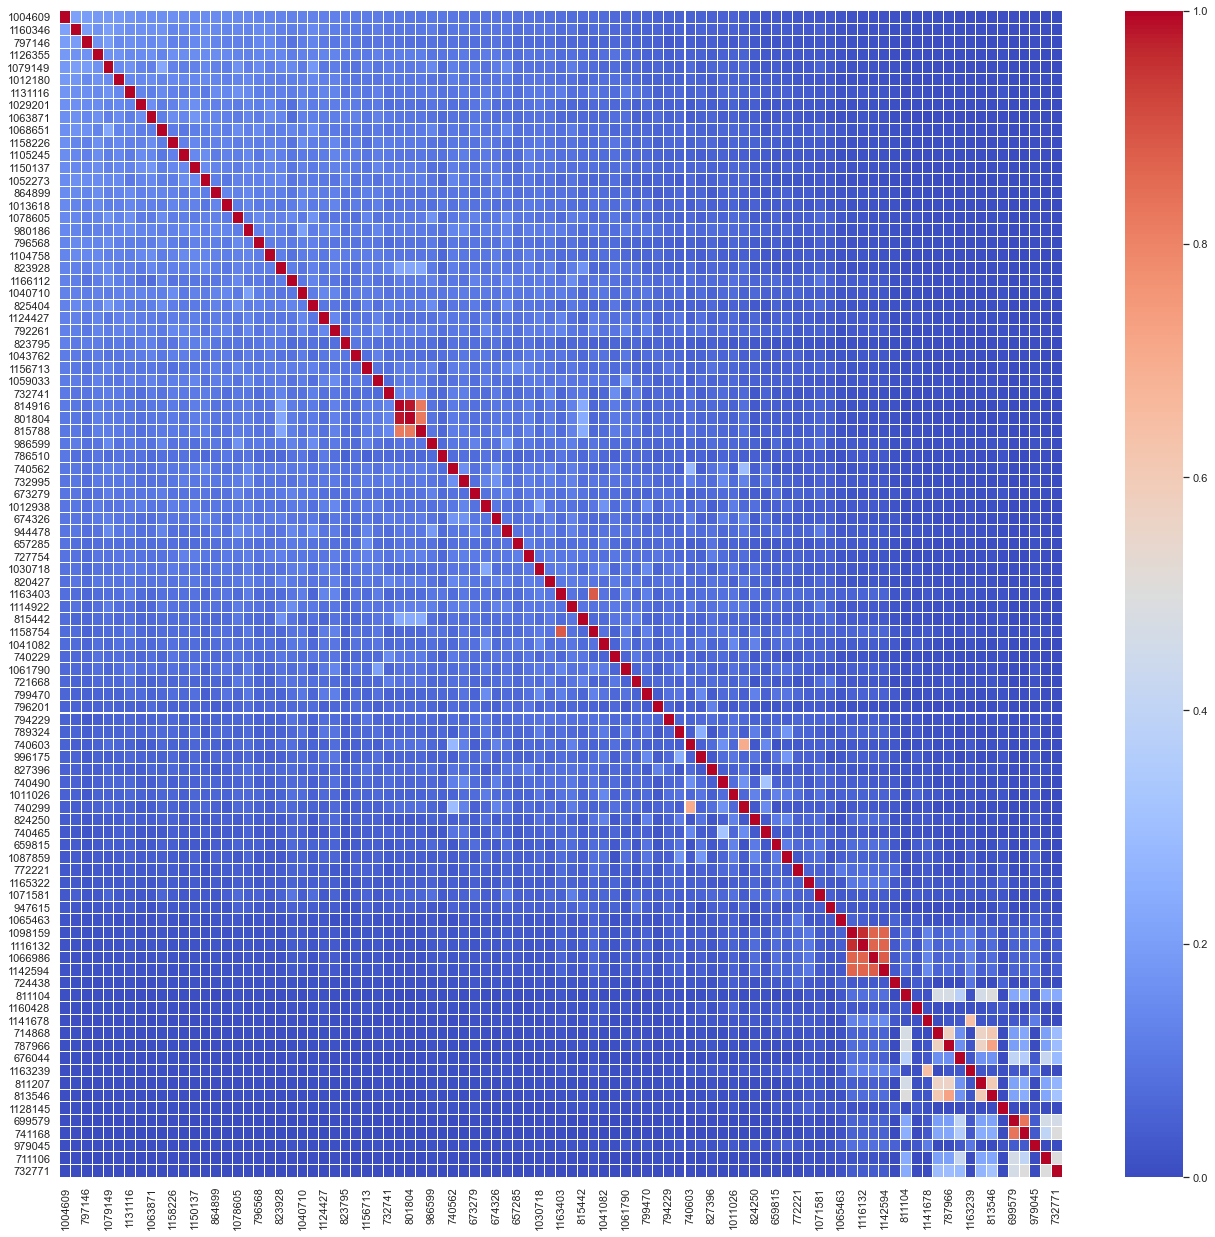

In [48]:
plt.figure(figsize=(20, 20))
ax = sns.heatmap(mapped_distances_df, cmap='coolwarm', linewidths=0.01)

# Bibliography

Overview of Text Similarity Metrics in Python. Sanket Gupta. [Available at](https://towardsdatascience.com/overview-of-text-similarity-metrics-3397c4601f50) Last visited: 24/04/2020 